# Create Image Example
create an image of the zodiacal light as seen from an imager near earth

In [5]:
# move to the working directory
%cd ..

/mnt/d/CodingProjects/zodiacal-polarized


In [46]:
# import the necessary modules
import astropy.units as u
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

from zodipol.mie_scattering.mie_scattering_model import MieScatteringModel
from zodipy_local.zodipy_local import Zodipy
from zodipol.imager.imager import Imager

In [7]:
# define a function to generate a spectrum
def generate_spectrum(imager):
    wavelength_range = imager.get_wavelength_range('red').values * u.nm
    imager_response = imager.get_camera_response(wavelength_range.value, 'red')
    frequency = wavelength_range.to(u.THz, equivalencies=u.spectral())  # Frequency of the observation

    top_frequencies = imager_response.argsort()[-5:]  # Top 5 frequencies

    frequency = frequency[top_frequencies]  # Select the top 5 frequencies
    wavelength = wavelength_range[top_frequencies]  # Select the top 5 wavelengths
    imager_response = imager_response[top_frequencies]  # Select the top 5 imager responses

    # sort by frequency
    frequency_ord = np.argsort(frequency)
    frequency = frequency[frequency_ord]
    wavelength = wavelength[frequency_ord]
    imager_response = imager_response[frequency_ord]
    return wavelength, frequency, imager_response

In [8]:
# define the parameters
nside = 256  # Healpix resolution
polarizance = 0.9  # Polarizance of the observation
fov = 5  # deg
polarization_angle = np.linspace(0, np.pi, 60, endpoint=False)  # Polarization angle of the observation

In [9]:
# Initialize the models
imager = Imager()
mie_model = MieScatteringModel.load('saved_models/white_light_mie_model.npz')
model = Zodipy("dirbe", solar_cut=30 * u.deg, extrapolate=True, parallel=True)  # Initialize the model

In [10]:
# Generate the spectrum
wavelength, frequency, imager_response = generate_spectrum(imager)
frequency_weight = np.ones_like(frequency)  # Weight of the frequencies

In [11]:
# Calculate the emission
binned_emission = model.get_binned_emission_pix(
        frequency,
        weights=frequency_weight,
        pixels=np.arange(hp.nside2npix(nside)),
        nside=nside,
        obs_time=Time("2022-06-14"),
        obs="earth",
        polarization_angle=polarization_angle,
        polarizance=polarizance,
        mie_scattering_model=mie_model)

In [12]:
# Calculate the polarization
emission_max, emission_min = np.max(binned_emission, axis=-1), np.min(binned_emission, axis=-1)
binned_polarization = (emission_max - emission_min) / (emission_max + emission_min)

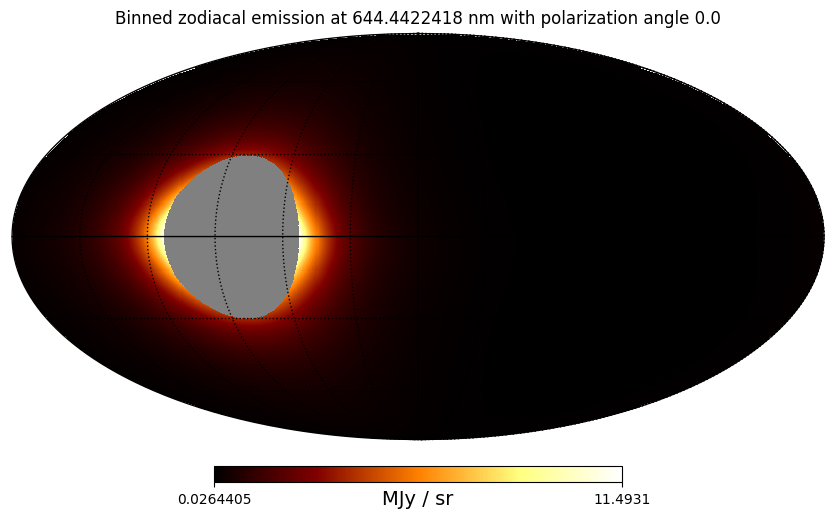

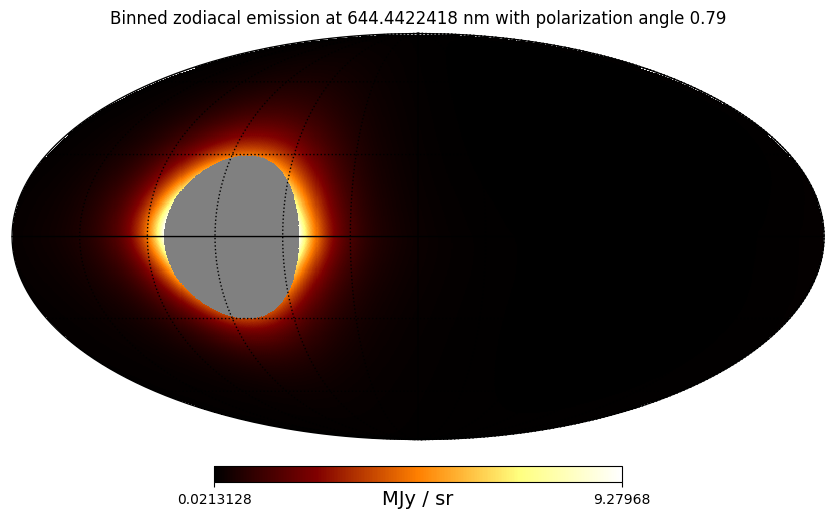

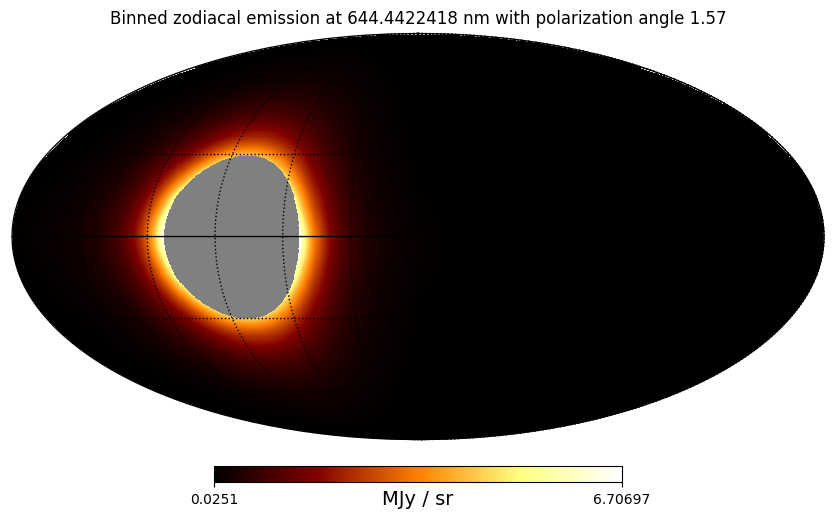

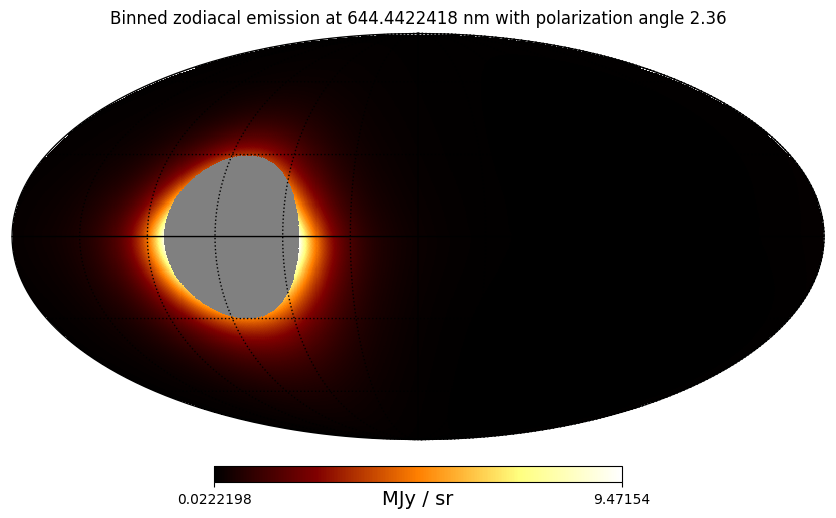

In [45]:
# Plot the polarized emission received by the imager
for ii in np.linspace(0, binned_emission.shape[-1], 4, endpoint=False, dtype=int):
    hp.mollview(
        binned_emission[..., 0, ii],
        title="Binned zodiacal emission at {} with polarization angle {}".format(wavelength[0],np.round(polarization_angle[ii], 2)),
        unit=str(binned_emission.unit),
        cmap="afmhot",
        rot=(0, 0, 0)
    )
    hp.graticule()
    plt.show()

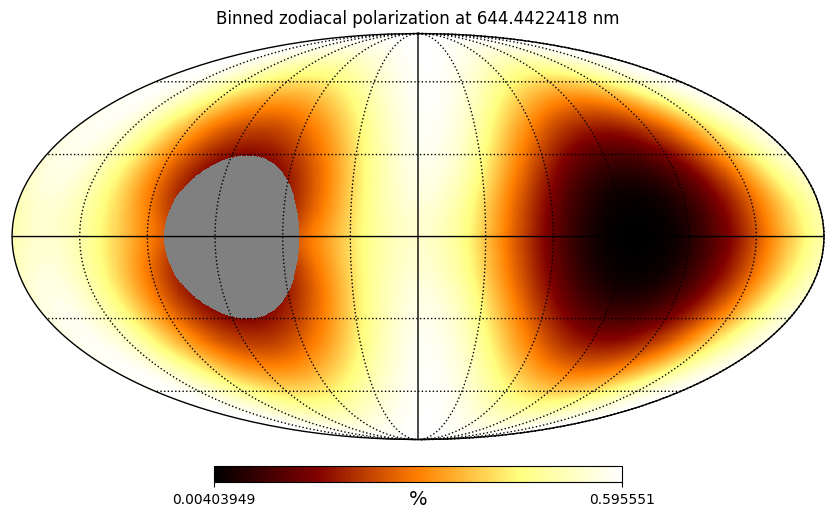

In [31]:
# Plot the polarization received by the imager
wavelength_ind = 0
hp.mollview(
    binned_polarization[:, wavelength_ind],
    title="Binned zodiacal polarization at {}".format(wavelength[wavelength_ind]),
    unit="%",
    cmap="afmhot",
    rot=(0, 0, 0)
)
hp.graticule()
plt.show()

In [47]:
# Calculate the realistic camera intensity and polarization received by the imager
n_electrons = imager.intensity_to_number_of_electrons(binned_emission, frequency, imager_response)
n_electrons_noised = imager.imager_noise_model(n_electrons)
camera_intensity = imager.number_of_electrons_to_intensity(n_electrons_noised, frequency, imager_response)

camera_intensity_max, camera_intensity_min = np.max(camera_intensity, axis=-1).value, np.min(camera_intensity, axis=-1).value
camera_polarization = (camera_intensity_max - camera_intensity_min) / (camera_intensity_max + camera_intensity_min + 1e-30)

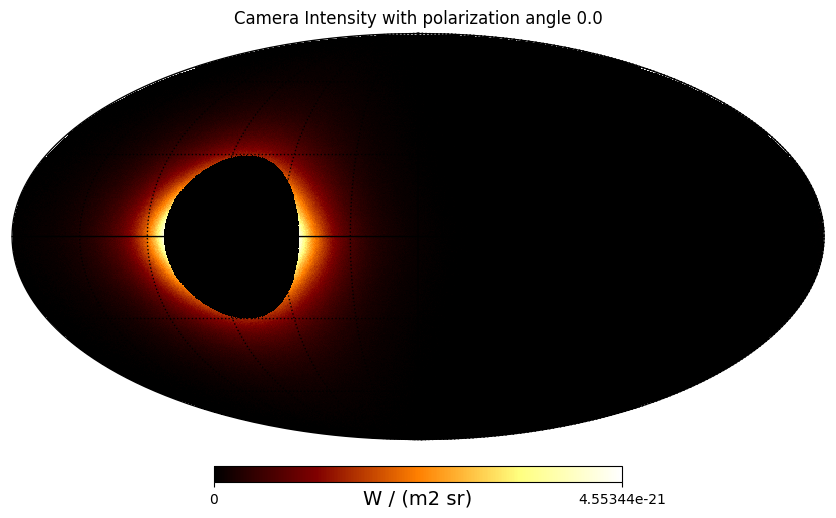

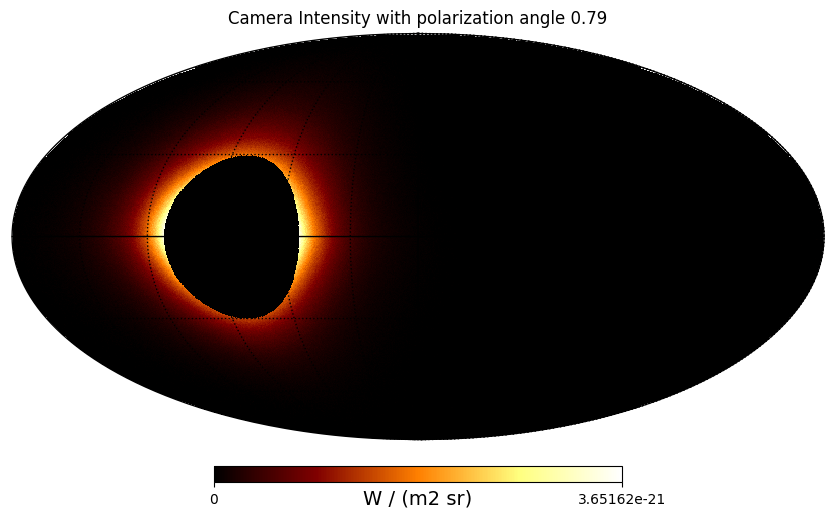

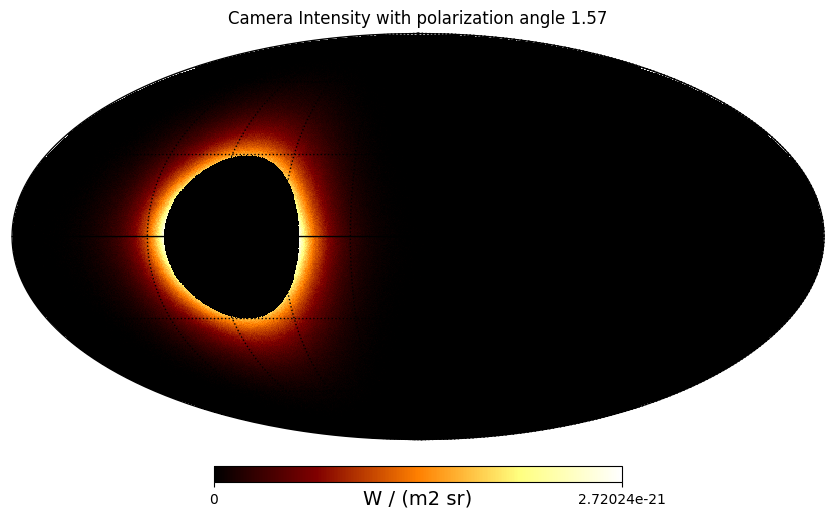

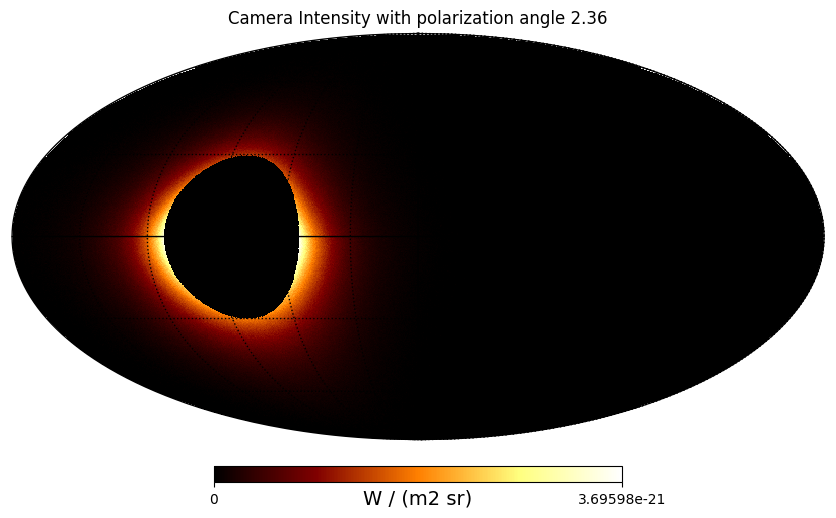

In [51]:
# Plot the camera intensity received by the imager
for ii in np.linspace(0, camera_intensity.shape[-1], 4, endpoint=False, dtype=int):
    hp.mollview(
        camera_intensity[..., ii],
        title="Camera Intensity with polarization angle {}".format(np.round(polarization_angle[ii], 2)),
        unit=str(camera_intensity.unit),
        min=0,
        cmap="afmhot",
        rot=(0, 0, 0)
    )
    hp.graticule()
    plt.show()

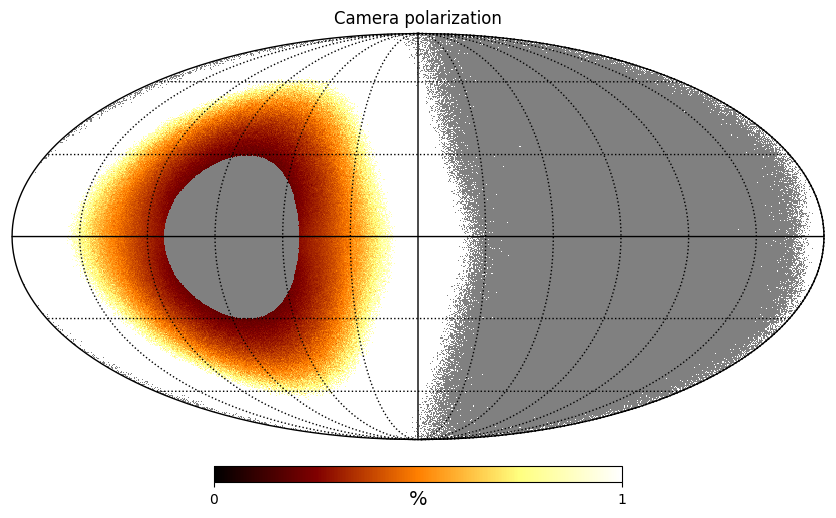

In [42]:
# Plot the camera polarization received by the imager
hp.mollview(
    camera_polarization,
    title="Camera polarization",
    unit="%",
    cmap="afmhot",
    min=0,
    max=1,
    rot=(0, 0, 0)
)
hp.graticule()
plt.show()